## 다변수 선형회귀: 다양한 정보가 있을 때 모델을 설계하고 학습하는 과정도 바로 진행해 보도록 하자.

## 손님의 성별, 수, 전체 먹은 금액 등으로 내가 받을 팁을 예측할 수 있을까?

In [64]:
# Step 2. 이번엔 하나가 아니다! 다양한 정보로 원하는 값을 예측해 보기

from IPython.display import display, Image
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [73]:
# seaborn은 간단한 데이터셋으로 여러 실험을 해 볼 수 있도록 샘플 데이터셋을 제공한다.
# 제공되는 데이터셋은 다음 함수로 확인할 수 있다.
import seaborn as sns
#- ! bs4 모듈이 설치되어 있어야 합니다. -#

sns.get_dataset_names()

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [74]:
# 우리가 오늘 사용해 볼 팁 데이터 가져오기
# 각 데이터는 total_bill, tip, sex, smoker, day, time, size 7개의 정보를 담고 있습니다.
# 각 컬럼은 다음과 같은 정보를 나타내죠.
# total_bill : 테이블의 전체 지불 금액
# tip : 팁으로 낸 금액
# sex : 웨이터의 성별
# smoker : 손님의 흡연 여부
# day : 요일
# time : 시간
# size : 테이블 인원수

tips = sns.load_dataset("tips")
print(tips.shape)
tips.head()

(244, 7)


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [75]:
# get_dummies() 함수를 활용해 문자열 데이터에 대해서는 0, 1 로 변환해주겠다. 
# 수식을 구할 때 카테고리형 데이터가 있다면 더미 변수(dummy variable)를 활용해 식에 포함시켜 줄 수 있다.
tips = pd.get_dummies(tips, columns=['sex', 'smoker', 'day', 'time'])
tips.head()

,total_bill,tip,size,sex_Male,sex_Female,smoker_Yes,smoker_No,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,time_Dinner
0,16.99,1.01,2,0,1,0,1,0,0,0,1,0,1
1,10.34,1.66,3,1,0,0,1,0,0,0,1,0,1
2,21.01,3.50,3,1,0,0,1,0,0,0,1,0,1
3,23.68,3.31,2,1,0,0,1,0,0,0,1,0,1
4,24.59,3.61,4,0,1,0,1,0,0,0,1,0,1


In [76]:
# 데이터 중 실수형 데이터가 아닌 카테고리 데이터일 때에는 pandas의 get_dummies 함수로 간편하게 숫자 데이터로 변환해줄 수 있다.
# 이러한 데이터 변환 방식을 원-핫 인코딩(One Hot Encoding)이라고 한다.
# 컬럼의 순서를 우리의 목적에 맞게 바꾸어보겠다.
# 우리는 나머지 모든 데이터를 가지고 최종적으로 tip 값을 예측하려고 한다. 
# 따라서 tip 컬럼을 맨 오른쪽에 두도록 하겠다.
tips = tips[['total_bill', 'size', 'sex_Male', 'sex_Female', 'smoker_Yes', 'smoker_No',
             'day_Thur', 'day_Fri', 'day_Sat', 'day_Sun', 'time_Lunch', 'time_Dinner', 'tip']]
tips.head()

,total_bill,size,sex_Male,sex_Female,smoker_Yes,smoker_No,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,time_Dinner,tip
0,16.99,2,0,1,0,1,0,0,0,1,0,1,1.01
1,10.34,3,1,0,0,1,0,0,0,1,0,1,1.66
2,21.01,3,1,0,0,1,0,0,0,1,0,1,3.50
3,23.68,2,1,0,0,1,0,0,0,1,0,1,3.31
4,24.59,4,0,1,0,1,0,0,0,1,0,1,3.61


## 다변수 일차방정식 만들기 

In [79]:
# 그러면 이제 본격적으로 데이터를 준비하고 모델을 설계해서 학습을 시켜 보겠습니다!
# 먼저 데이터는 다음과 같이 준비하면 됩니다. 
# 다만, 앞으로는 X는 하나의 값이 아닌 12개의 값을 가지는 벡터 이므로, 대문자로 표기하도록 하겠습니다.
X = tips[['total_bill', 'size', 'sex_Male', 'sex_Female', 'smoker_Yes', 'smoker_No',
          'day_Thur', 'day_Fri', 'day_Sat', 'day_Sun', 'time_Lunch', 'time_Dinner']].values
y = tips['tip'].values

In [80]:
# 데이터를 train 데이터와 test 데이터로 분리한다.
# 모델이 일정량의 데이터로 학습한 뒤 그 모델을 공정하게 평가하기 위해서는 학습 과정에서 보지 못했던 데이터를 이용해야 한다.
# sklearn 라이브러리에 내장되어 있는 train_test_split을 활용해 데이터를 분리해 보도록 하겠다.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(195, 12) (195,)
(49, 12) (49,)


In [82]:
# W와 b는 랜덤한 값으로 초기값을 설정해주도록 하겠습니다. W 또한 벡터이므로 대문자를 사용합니다.
# 길이가 12인 W와 1개의 숫자인 b를 준비합니다.
W = np.random.rand(12)
b = np.random.rand()

In [83]:
W

array([0.0082938 , 0.54471227, 0.21907975, 0.70975933, 0.08909805,
       0.36611047, 0.94852479, 0.41792378, 0.94585177, 0.8223529 ,
       0.59771164, 0.85853855])

In [84]:
b

0.9957061844791711

In [85]:
# 따라서 for 구문을 활용해 1부터 12까지 x * w를 수행하고, 마지막에 b를 더해주도록 하겠습니다.
def model(X, W, b):
    predictions = 0
    for i in range(12):
        predictions += X[:, i] * W[i]
    predictions += b
    return predictions

In [86]:
# 손실함수는 이번에는 RMSE 대신 MSE를 사용해 보겠다. 
# 이전에 사용했던 RMSE는 단지 MSE의 제곱근이었으므로, 이번에는 제곱근하는 과정만 빼면 된다.
def MSE(a, b):
    mse = ((a - b) ** 2).mean()  # 두 값의 차이의 제곱의 평균
    return mse

In [46]:
# 손실함수
def loss(X, W, b, y):
    predictions = model(X, W, b)
    L = MSE(predictions, y)
    return L

In [87]:
# MSE Loss에 대해 미분 공식을 활용해서 직접 그래디언트 수식을 구하고 함수 구현하기
def gradient(X, W, b, y):
    # N은 데이터의 개수
    N = len(X)
    
    # y_pred 준비
    y_pred = model(X, W, b)
    
    # 공식에 맞게 gradient 계산
    dW = 1/N * 2 * X.T.dot(y_pred - y)
        
    # b의 gradient 계산
    db = 2 * (y_pred - y).mean()
    return dW, db
len(X)

244

In [88]:
# 한번 실험삼아 경사(gradient)를 계산해 볼까요?
dW, db = gradient(X, W, b, y)
print("dW:", dW)
print("db:", db)

dW: [63.83130168  9.42169271  2.13776682  1.59948769  1.20703582  2.53021869
  1.02618532  0.20701831  1.39562409  1.1084268   1.09212217  2.64513235]
db: 3.7372545167022624


## 직접 구현한 손실함수, 기울기 함수를 활용해 경사하강법으로 모델 학습하기

In [89]:
# 학습률을 0.0001로 두겠습니다.
LEARNING_RATE = 0.0001

In [90]:
# gradient를 구하고, W와 b를 업데이트하고, 손실함수를 기록합니다.

losses = []

for i in range(1, 1001):
    dW, db = gradient(X_train, W, b, y_train)
    W -= LEARNING_RATE * dW
    b -= LEARNING_RATE * db
    L = loss(X, W, b, y)
    losses.append(L)
    if i % 10 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

Iteration 10 : Loss 3.1598
Iteration 20 : Loss 2.8843
Iteration 30 : Loss 2.8307
Iteration 40 : Loss 2.8138
Iteration 50 : Loss 2.8045
Iteration 60 : Loss 2.7974
Iteration 70 : Loss 2.7909
Iteration 80 : Loss 2.7846
Iteration 90 : Loss 2.7785
Iteration 100 : Loss 2.7724
Iteration 110 : Loss 2.7664
Iteration 120 : Loss 2.7603
Iteration 130 : Loss 2.7543
Iteration 140 : Loss 2.7484
Iteration 150 : Loss 2.7424
Iteration 160 : Loss 2.7365
Iteration 170 : Loss 2.7306
Iteration 180 : Loss 2.7247
Iteration 190 : Loss 2.7188
Iteration 200 : Loss 2.7130
Iteration 210 : Loss 2.7072
Iteration 220 : Loss 2.7014
Iteration 230 : Loss 2.6956
Iteration 240 : Loss 2.6899
Iteration 250 : Loss 2.6842
Iteration 260 : Loss 2.6785
Iteration 270 : Loss 2.6728
Iteration 280 : Loss 2.6672
Iteration 290 : Loss 2.6616
Iteration 300 : Loss 2.6560
Iteration 310 : Loss 2.6504
Iteration 320 : Loss 2.6448
Iteration 330 : Loss 2.6393
Iteration 340 : Loss 2.6338
Iteration 350 : Loss 2.6283
Iteration 360 : Loss 2.6228
I

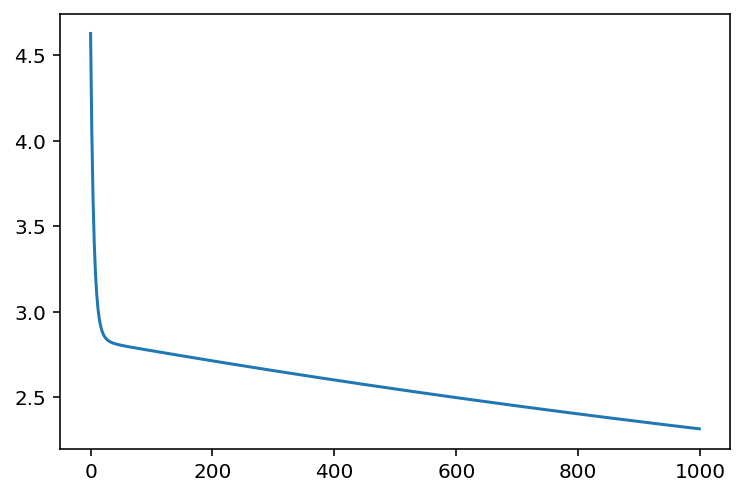

In [91]:
# 손실함수를 그려보자
plt.plot(losses)
plt.show()

In [92]:
# W와 b의 값을 확인해보자
W, b

(array([-0.02653334,  0.38987643,  0.1936631 ,  0.64297068,  0.07325206,
         0.28975116,  0.91151204,  0.41533094,  0.91018297,  0.80542199,
         0.55756677,  0.80647812]),
 0.9035008776201365)

In [93]:
# 학습때 보지 않은 test 데이터에 대해서는 loss값이 얼마나 될까요? 
prediction = model(X_test, W, b)
mse = loss(X_test, W, b, y_test)
mse

2.285702333680676

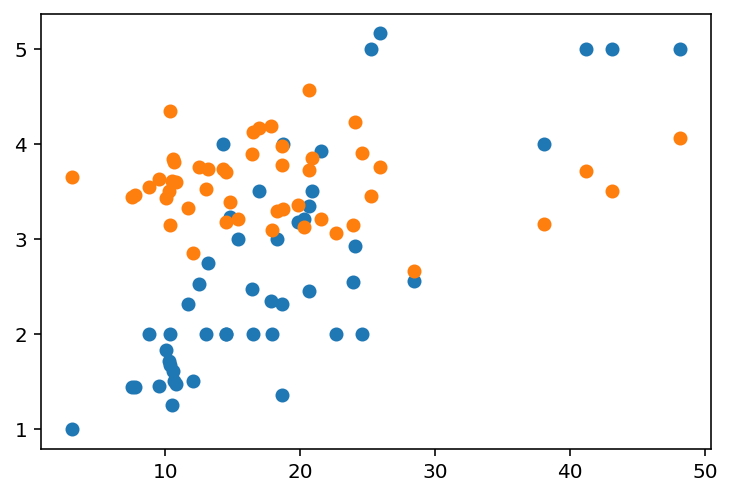

In [94]:
# 마지막으로 우리의 모델이 예측한 prediction과 실제 정답인 y_test를 비교해서 얼마나 잘 맞추었는지 그래프로 확인해 보도록 하겠습니다.
# X_test의 각 행의 첫 번째 데이터가 total_bill이므로, 다음과 같이 시각화를 하면 됩니다.
plt.scatter(X_test[:, 0], y_test)
plt.scatter(X_test[:, 0], prediction)
plt.show()

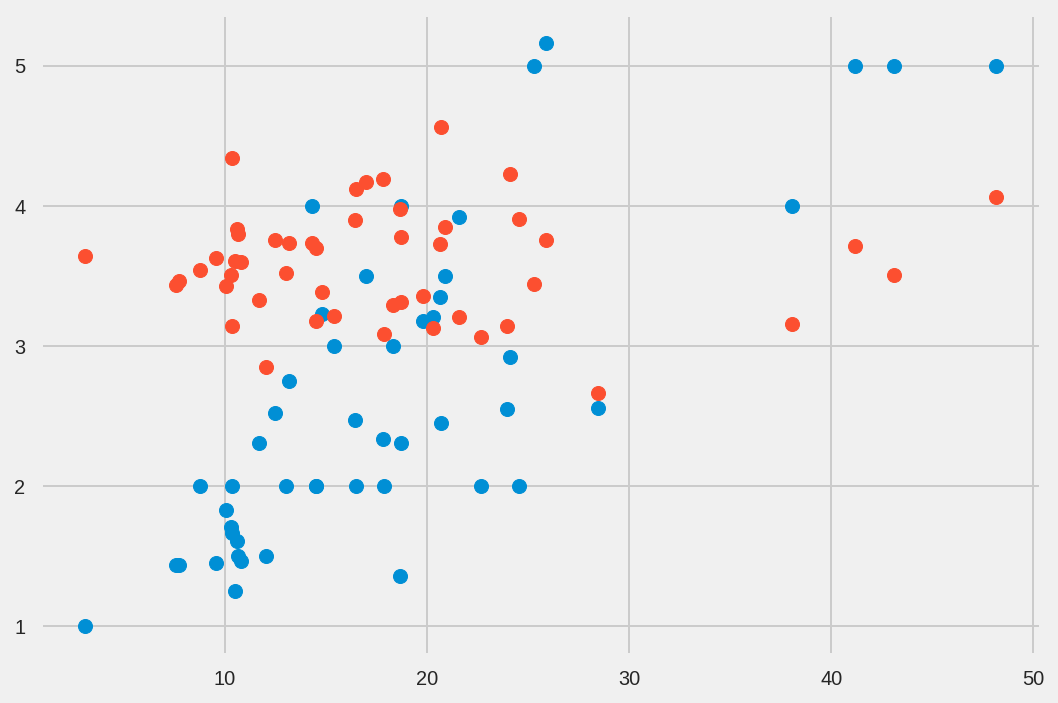

In [106]:
# 다양한 그래픽 스타일로 연출해보자
plt.style.use('fivethirtyeight') #ggplot, ggplot2, seaborn, seaborn

plt.scatter(X_test[:, 0], y_test)
plt.scatter(X_test[:, 0], prediction)
plt.show()

In [107]:
# 이제 지금까지 학습한 모든 내용을 사이킷런(sklearn) 라이브러리를 활용해서 아주 편리하고 깔끔하게 진행해 보자
tips = sns.load_dataset("tips")
tips = pd.get_dummies(tips, columns=['sex', 'smoker', 'day', 'time'])
tips = tips[['total_bill', 'size', 'sex_Male', 'sex_Female', 'smoker_Yes', 'smoker_No',
             'day_Thur', 'day_Fri', 'day_Sat', 'day_Sun', 'time_Lunch', 'time_Dinner', 'tip']]

In [108]:
# X와 y를 준비하자
X = tips[['total_bill', 'size', 'sex_Male', 'sex_Female', 'smoker_Yes', 'smoker_No',
          'day_Thur', 'day_Fri', 'day_Sat', 'day_Sun', 'time_Lunch', 'time_Dinner']].values
y = tips['tip'].values

## X와 y를 train 데이터와 test 데이터로 분리해 봅시다.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
# 데이터가 준비되었으니 우리는 준비된 모델을 가져다 쓰기만 하면 됩니다.
# 선형회귀 모델은 sklearn.linear_model 안에 LinearRegression 로 내장되어 있습니다.

from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [110]:
# 모델 학습은 다음과 같이 입력 데이터에 해당하는 X_train과 정답 데이터에 해당하는 y_train을 넣어 fit 시키면 됩니다.

model.fit(X_train, y_train)

LinearRegression()

In [112]:
# X_test 데이터에 대한 예측을 해 볼까요?

predictions = model.predict(X_test)
predictions

array([2.91436632, 2.00292613, 3.96425583, 3.76380832, 2.14836306,
       2.67423448, 3.63934628, 2.29147245, 2.57207155, 2.45851225,
       2.90446763, 2.0573337 , 2.11817193, 2.35130838, 1.82976215,
       3.10830675, 2.95140176, 3.21602976, 2.56640892, 5.73957295,
       3.43490366, 3.22645102, 2.17139823, 1.94180002, 3.16394533,
       2.24547894, 2.14497574, 3.21025435, 3.20097595, 6.66803147,
       5.01111235, 1.57804024, 3.1909877 , 2.76652194, 2.98412862,
       3.85695724, 2.17008741, 5.46673999, 2.35586827, 2.99190732,
       2.03271177, 2.48465991, 3.44046814, 2.35532237, 1.92528104,
       0.87348926, 1.81911521, 3.04083954, 1.85436902])

In [113]:
# 이제 정답 데이터와 비교해 모델의 성능을 평가해 봅시다.
#모델의 성능은 mse로 계산해 볼텐데, 이는 sklearn.metrics의 mean_squared_error에 들어있습니다.

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
mse

0.7033566017436103

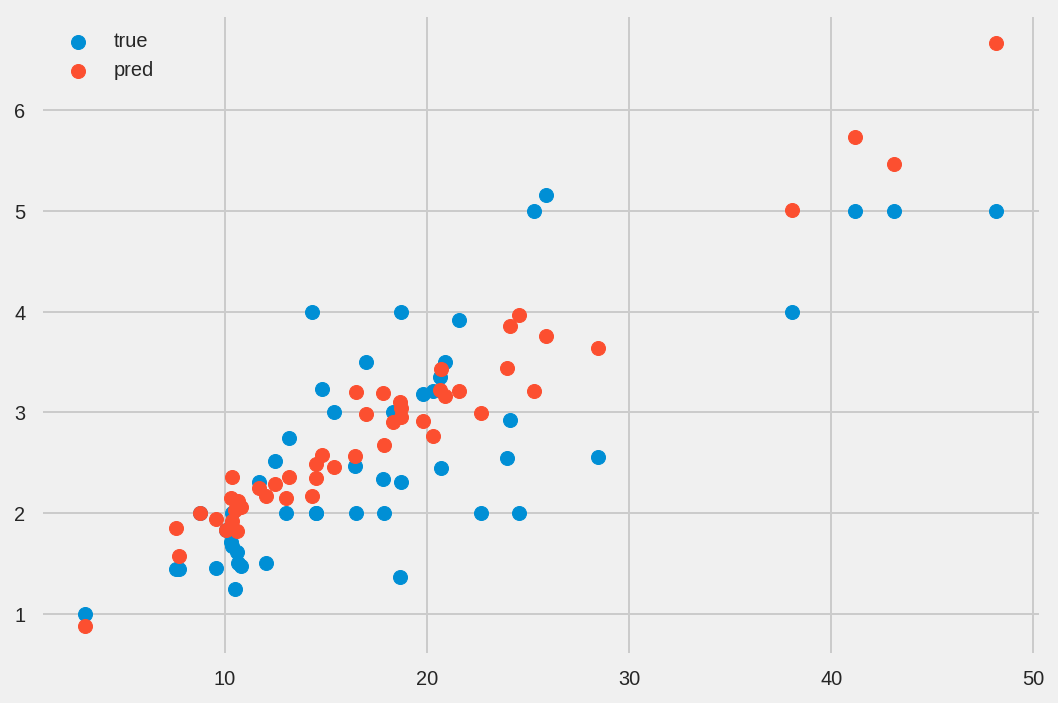

In [114]:
# 위에서 했던 것과 같이 X축에는 total_bill을, y 축에는 tip을 두고 시각화를 해 보겠습니다.
plt.scatter(X_test[:, 0], y_test, label="true")
plt.scatter(X_test[:, 0], predictions, label="pred")
plt.legend()
plt.show()

In [115]:
# 여기까지가 오늘의 학습 내용입니다.
# 다시 상기해 보자면, 오늘 우리가 풀어본 문제는 머신러닝 중에서도 "선형 회귀" 문제였습니다.

# 사실 앞으로는 회귀 문제를 이렇게 풀지 않고 기울기나 모델 학습 과정은 텐서플로우에 내장된 편리한 함수들을 이용하게 될 것입니다.
# 하지만, 이미 편하게 쓸 수 있도록 구현되어 있는 라이브러리를 사용할 때에도 내가 무엇을 하려고 이 라이브러리를 사용하고 있는지를 이해하고 쓰는 것과 아닌 것은 매우 큰 차이가 있죠!

# 오늘 배운 내용을 정리해 보자면,

# 입력데이터인 X, 정답데이터인 y, 모델의 출력인 prediction, 각각의 개념을 알고, 정답데이터에 가까운 출력을 낼 수 있도록 학습한다는 철학을 이해해 보았고,
# 손실함수의 개념과 손실함수가 필요한 이유를 이해하고, 쓸 수 있는 함수의 종류를 알아보았으며 직접 구현해 보았습니다.
# 또한, 손실함수를 미분해서 구하는 기울기는 손실함수값을 줄이기 위해 필요한 것임을 이해하고, 그 구현을 수치미분과 해석미분 두 가지 방법으로 진행했죠.
# 그리고, 선형 방정식 형태로 된 모델을 학습시켜 실수형 데이터를 예측하는 선형 회귀 프로젝트의 전체 프로세스를 경험하고 익혀보았습니다.
# 마지막으로는 사이킷런을 활용해서 간편하고 빠르게 선형 회귀를 진행해 보기도 했어요!